In [2]:
import pandas as pd
import helpers as h
import empatica_helpers as eh
import inquisit_helpers as ih
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(h), reload(eh), reload(ih)

# Global settings
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('ggplot') # nicer plots
pd.set_option('display.max_columns', None)

# Full pipeline
# e_raw, _ = eh.load_empatica(data_folder='input/empatica/', useIBI=False, save=False, plotTrimmings=False)
# i_raw = ih.load_inquisit(data_folder='input/inquisit/', save=False)
# ei_raw = h.combine_empatica_and_inquisit(e_raw, i_raw, save=False)
# ei_prep = h.preprocess_data(save=True)

df = h.get_features(save=False)

# for s in range(8, 20, 2):
#     for ref in ['tnt', 'nt']:
#         h.get_features(save=True, s=s, reference_class=ref)

# X_train, y_train, X_val, y_val, X_test, y_test, X_train_val, y_train_val, train_idx, train_wval_idx, val_idx, test_idx, df, feature_names, participants = h.prepare_datasets(df=df, test_size=0.1, val_size=0.1) 

# assert len(feature_names) == X_train.shape[1]

Engineering features...


/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/helpers.py:187: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


AttributeError: 'RollingGroupby' object has no attribute 'shift'

In [6]:
def get_features(df = None, filename='output/ei_prep.csv', s=8, sr=64, save=False, reference_class='tnt'):
    print('Engineering features...')
    # Meant for 'output/combined_feature_engineered_tnt_only.csv'
    # Data loading
    if df is None:
        df = pd.read_csv(filename)
    
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Calculate the window size in samples
    win = sr*s

    # Group by 'session_id'
    temp = df.groupby('session_id')

    shift_val = -(win - 8*sr) # Shifts the label to the left by the window size in excess of 8 seconds, so the label is always 8s to the right of the left window edge, and the remainder of the window is to the right of the label. 

    columns = ['eda_tonic', 'eda_phasic', 'body_acc', 'temp', 'hr', 'bvp']
    operations = ['mean', 'std', 'min', 'max', 'skew', 'kurt']

    for col in columns:
        for op in operations:
            df[f'{col}_{op}'] = temp[col].shift(shift_val).rolling(window=win).agg(op).reset_index(0, drop=True)

    if reference_class == 'tnt':
        # Only keep rows that dont have nan for intrusion_tnt 
        df = df.dropna(subset=['intrusion_tnt'])
        # Rename intrusion_tnt to intrusion
        df = df.drop(columns=['intrusion_nothink', 'intrusion'])
        df = df.rename(columns={'intrusion_tnt': 'intrusion'})
    elif reference_class == 'nt':
        # Only keep rows that dont have nan for intrusion_nothink
        df = df.dropna(subset=['intrusion_nothink'])
        # Rename intrusion_nothink to intrusion
        df = df.drop(columns=['intrusion_tnt', 'intrusion'])
        df = df.rename(columns={'intrusion_nothink': 'intrusion'})
    elif reference_class == 'all':
        # Keep all rows
        df = df.drop(columns=['intrusion_nothink', 'intrusion_tnt'])
    else:
        raise ValueError("reference_class must be 'tnt' or 'nt'")

    df = df.drop(columns=['temp', 'hr', 'eda', 'body_acc', 'bvp', 'eda_tonic', 'eda_phasic'])
    df = df.drop(columns=['session_id', 'session_duration'])

    if save:
        df.to_csv(f'output/dataset_{reference_class}_win{s}.csv', index=False)

    print('Feature engineering done!')
    return df

df = get_features(save=False)
df.to_csv('output/features_win8_new.csv', index=False)

Engineering features...


/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_38861/582820457.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Feature engineering done!


In [7]:
df1 = pd.read_csv('output/features_win8_new.csv')
df2 = pd.read_csv('output/features_win8_new.csv')

assert df1.equals(df2)

## Dummy classifier

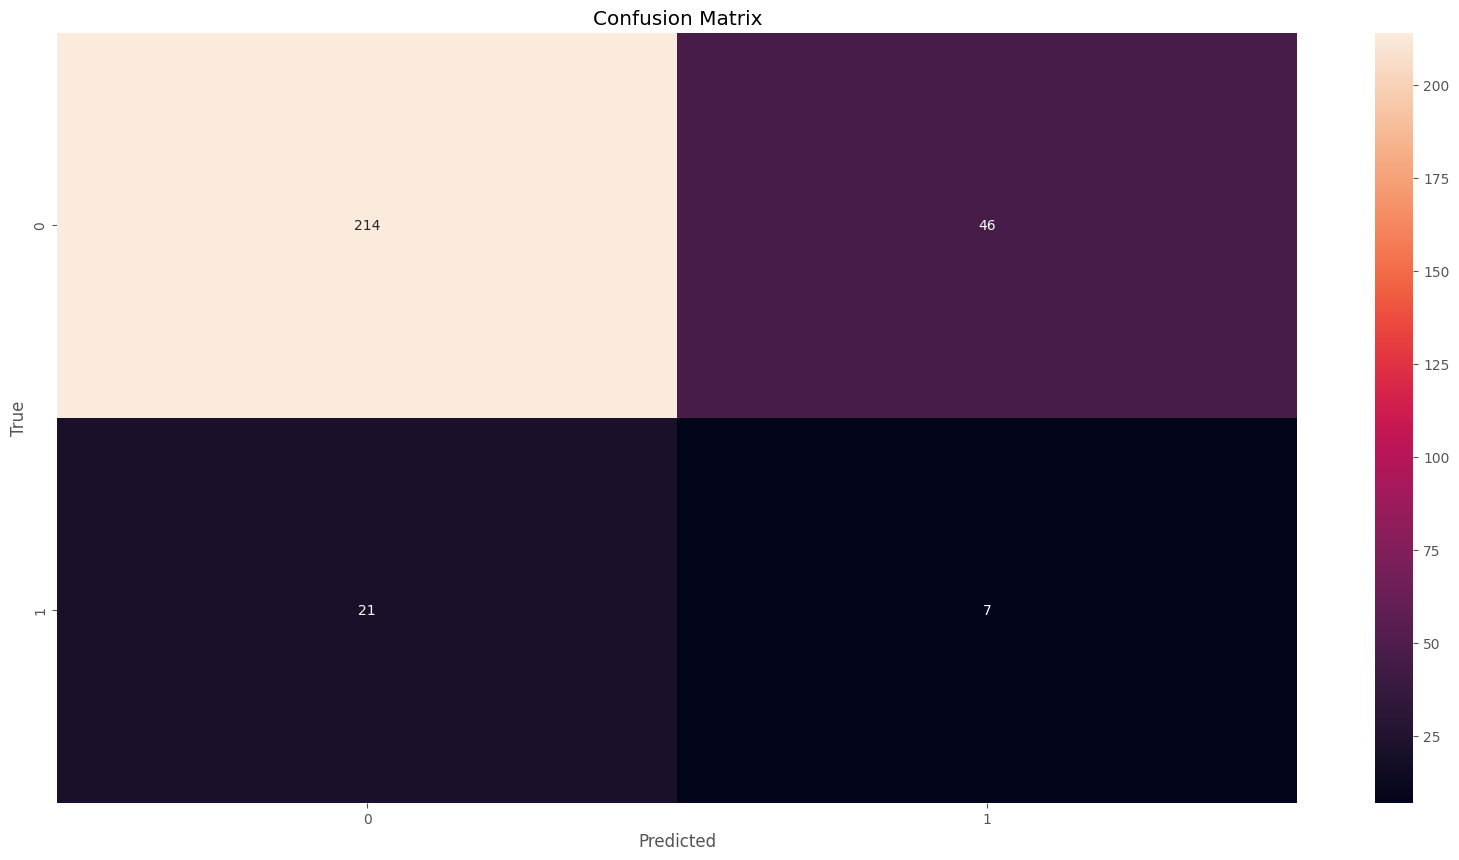

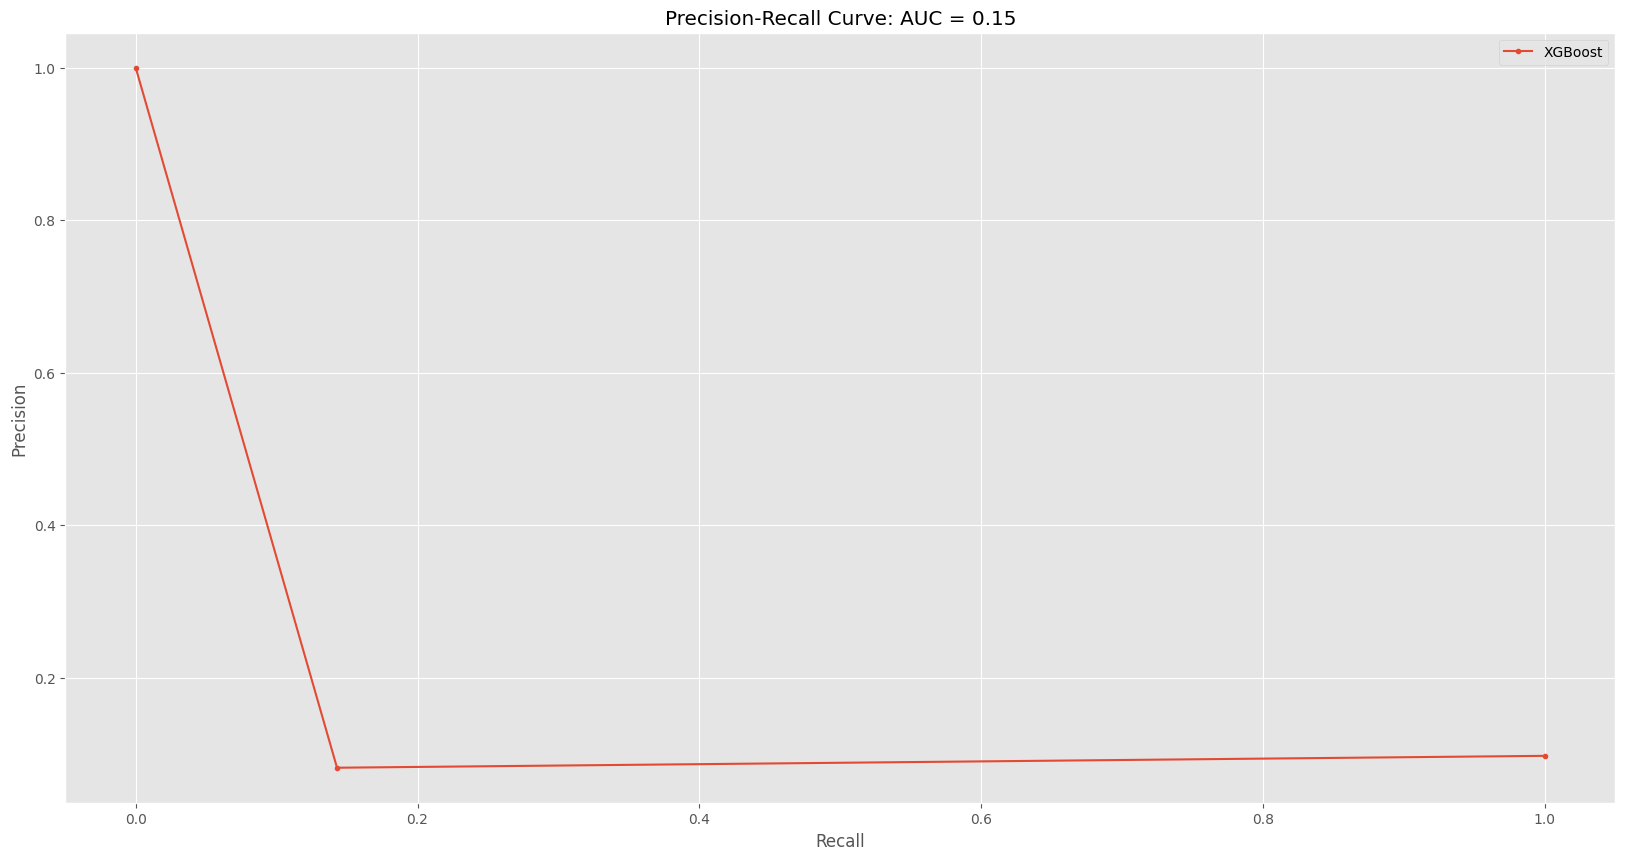

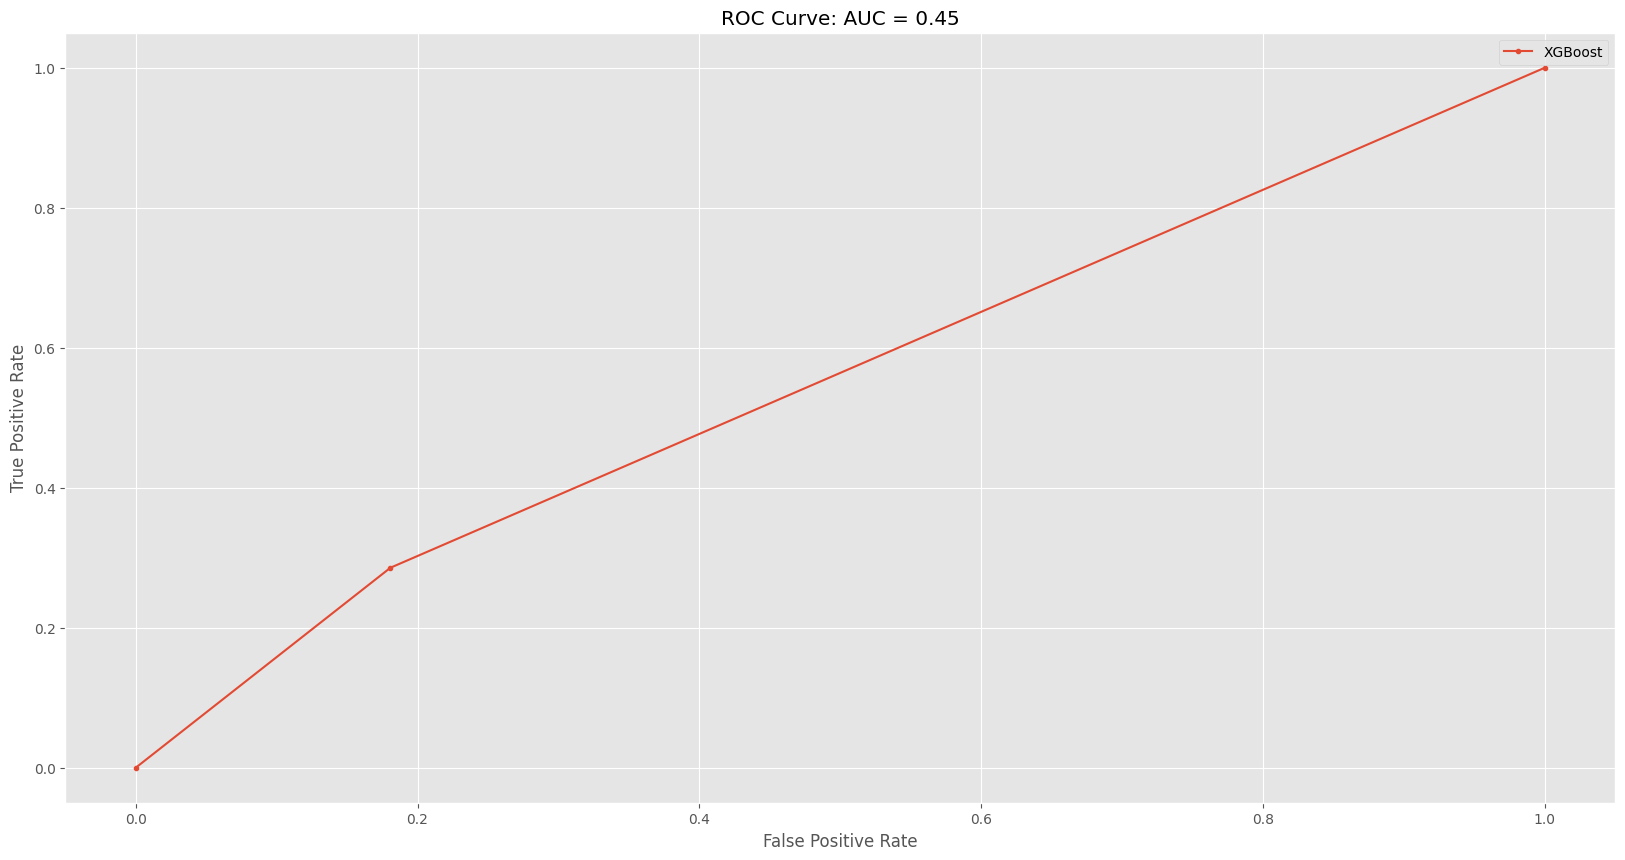

In [43]:
# Fit a dummy classifier
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

h.plot_metrics(y_val, y_pred, model, X_val)


## XGB

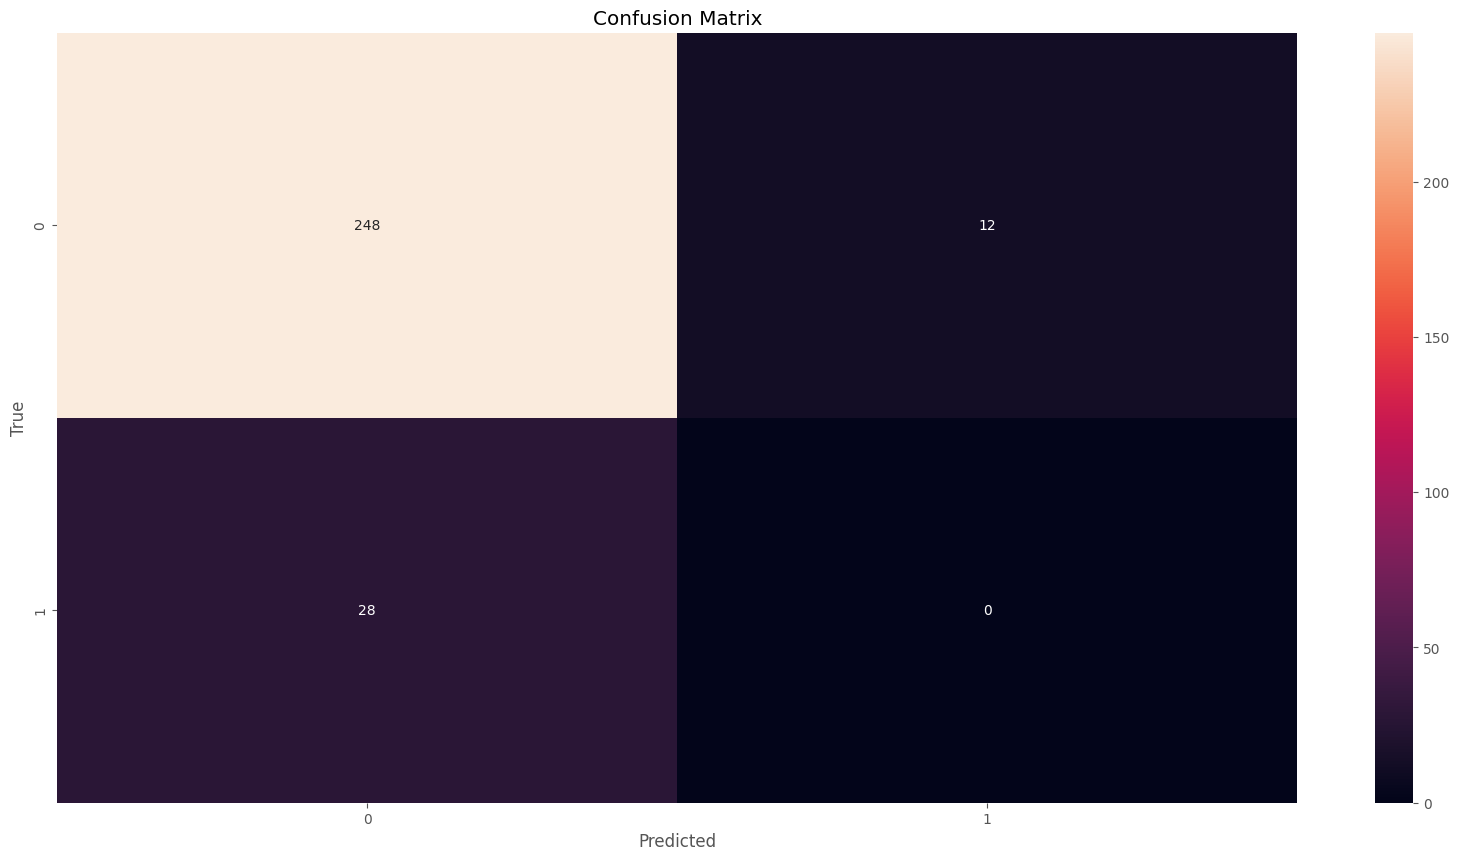

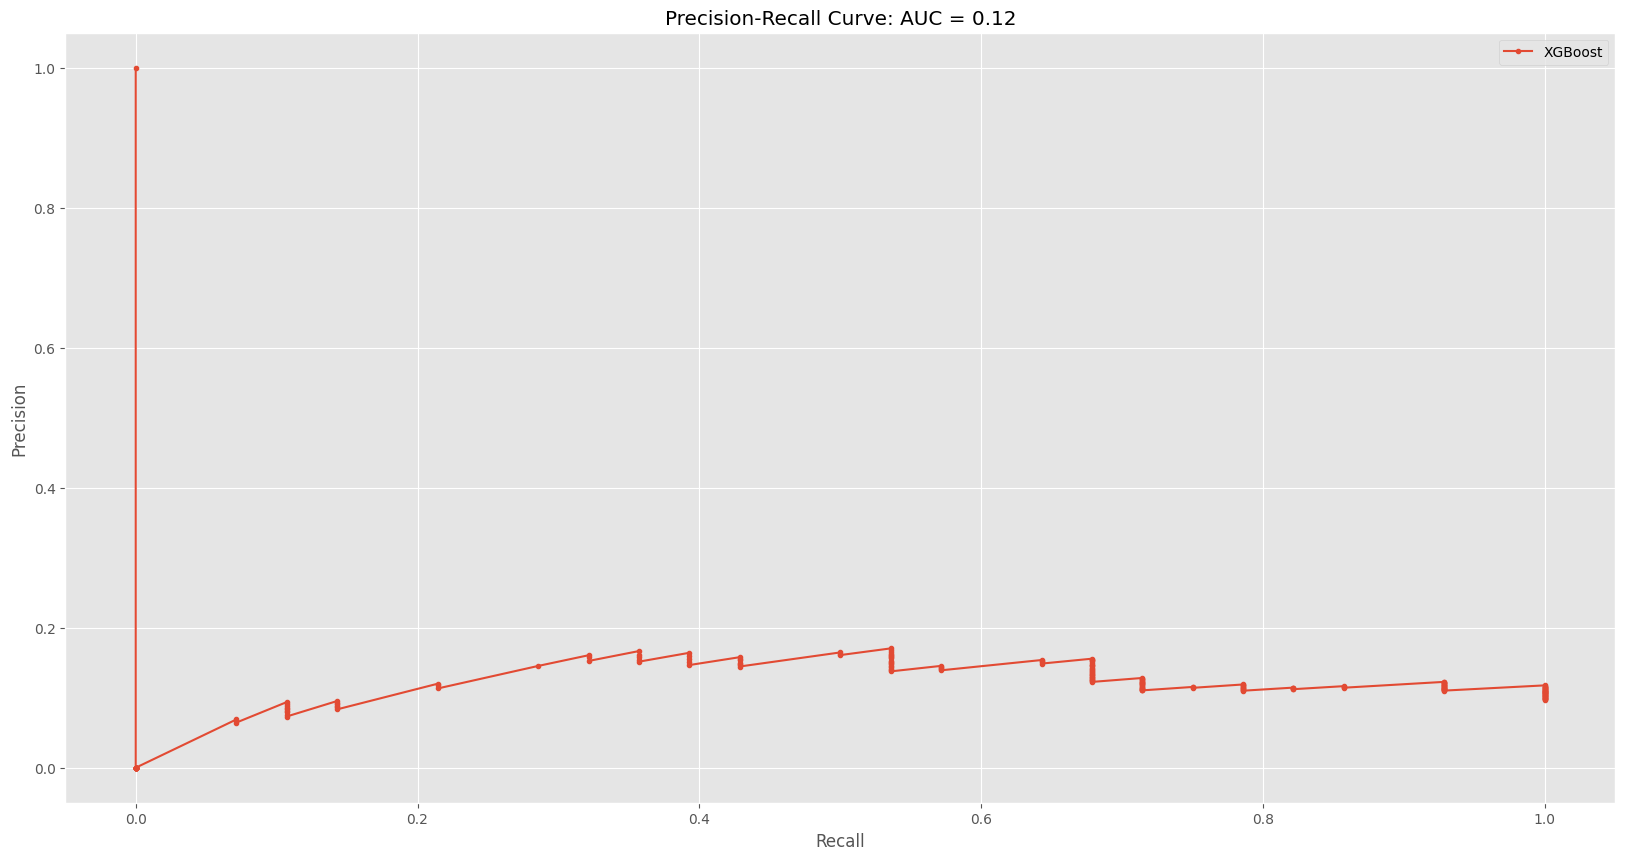

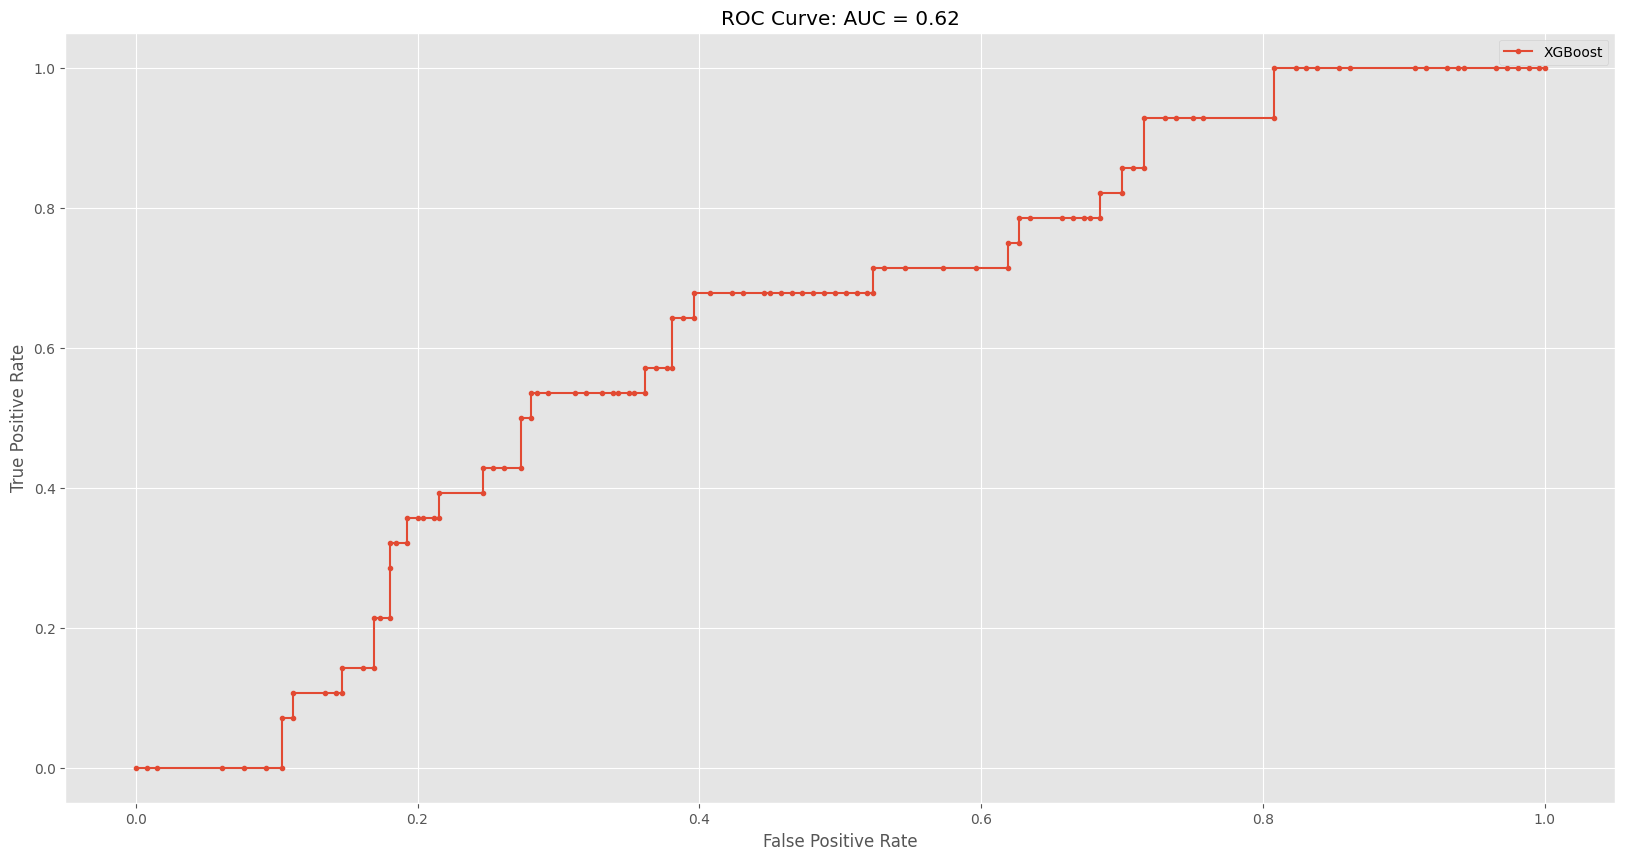

In [44]:
import xgboost as xgb

# Define the hyperparameter space
counts = y_train.value_counts()
scale_pos_weight = counts[0] / counts[1] # Recommended by: https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9&sca_esv=254eb9c569a53dbc&strip=1&vwsrc=0

# Initialize an XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = model.predict(X_val)

# Plot the metrics
h.plot_metrics(y_val, y_pred, model, X_val)

## Bayesian Hyperparameter Optimisation

In [40]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import average_precision_score

# Define the hyperparameter space
counts = y_train.value_counts()
scale_pos_weight = counts[0] / counts[1] # Recommended by: https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9&sca_esv=254eb9c569a53dbc&strip=1&vwsrc=0

# Default recommendations: https://bradleyboehmke.github.io/xgboost_databricks_tuning/tutorial_docs/xgboost_hyperopt.html
space = {
    'objective':'binary:logistic',
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 15),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),
    'n_estimators': hp.choice('n_estimators', range(50, 5000)),
    'gamma': hp.choice('gamma', [0, hp.loguniform('gamma_log', np.log(1), np.log(1000))]),
    'reg_lambda': hp.choice('reg_lambda', [0, hp.loguniform('reg_lambda_log', np.log(1), np.log(1000))]),
    'reg_alpha': hp.choice('reg_alpha', [0, hp.loguniform('reg_alpha_log', np.log(1), np.log(1000))]),
    'scale_pos_weight': scale_pos_weight
}

# Define the objective function
def objective(params):
    # Initialize an XGBoost classifier
    model = xgb.XGBClassifier(**params, random_state=42)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the probabilities on the validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate the AUPRC
    auprc = average_precision_score(y_val, y_pred_proba)

    return {'loss': -auprc, 'status': STATUS_OK}

# Run the hyperparameter search
best = fmin(fn=objective, space=space, max_evals=100, rstate=np.random.RandomState(42), algo=tpe.suggest)

# Print the best hyperparameters
print(best)

100%|██████████| 100/100 [03:11<00:00,  1.92s/trial, best loss: -0.18632935754739005]
{'colsample_bylevel': 0.9181655846046277, 'colsample_bynode': 0.6961521821270974, 'colsample_bytree': 0.7605794874971781, 'gamma': 1, 'gamma_log': 3.989444349318751, 'learning_rate': 0.002304325653715627, 'max_depth': 8, 'min_child_weight': 2.3138795428622996, 'n_estimators': 4908, 'reg_alpha': 1, 'reg_alpha_log': 76.33210108871064, 'reg_lambda': 1, 'reg_lambda_log': 14.722987861623384, 'subsample': 0.9247738424797534}


/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/.conda/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma_log", "reg_alpha_log", "reg_lambda_log" } are not used.

  warnings.warn(smsg, UserWarning)


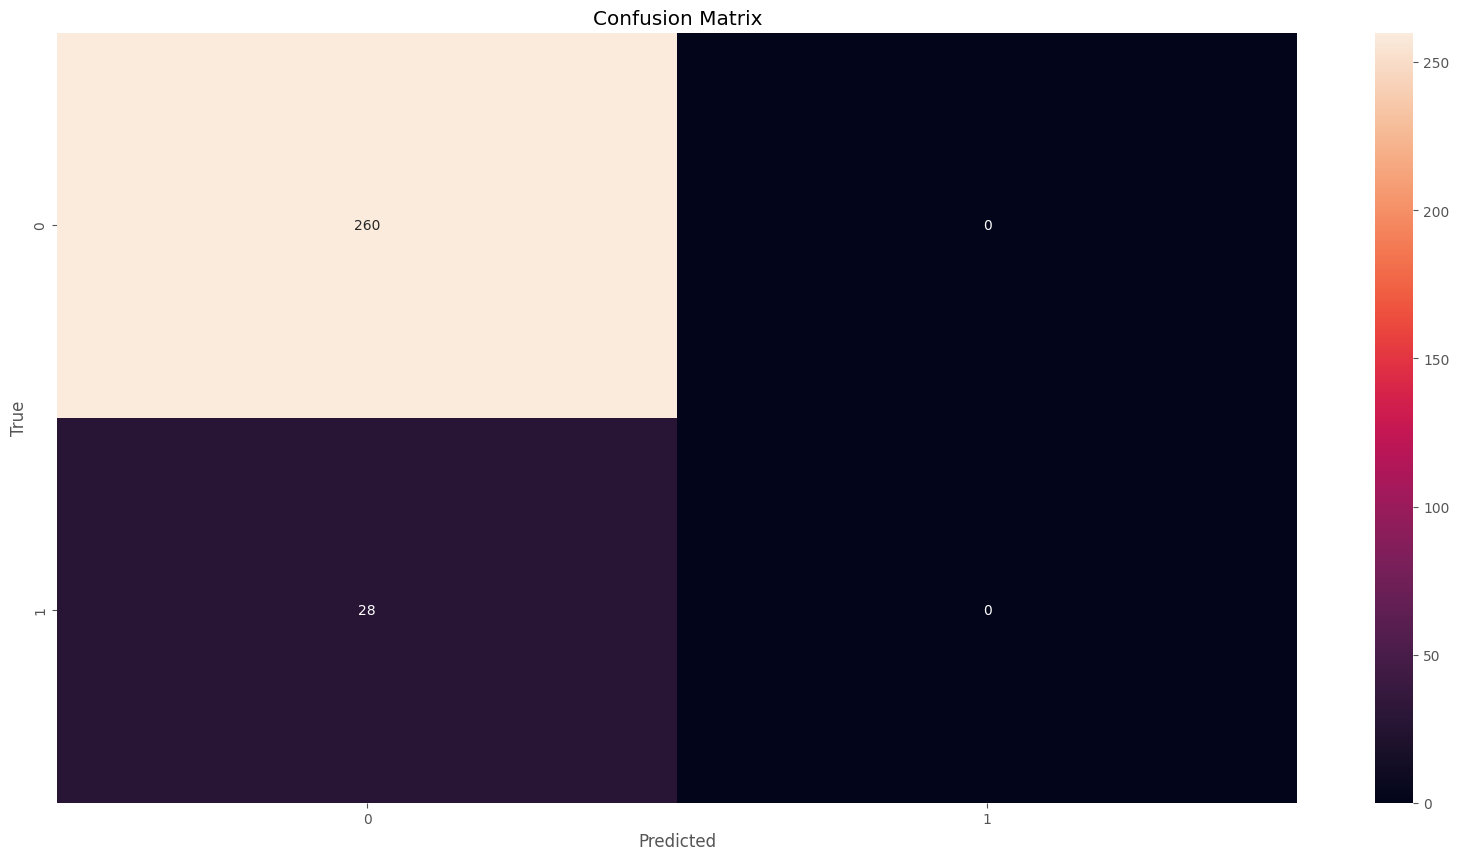

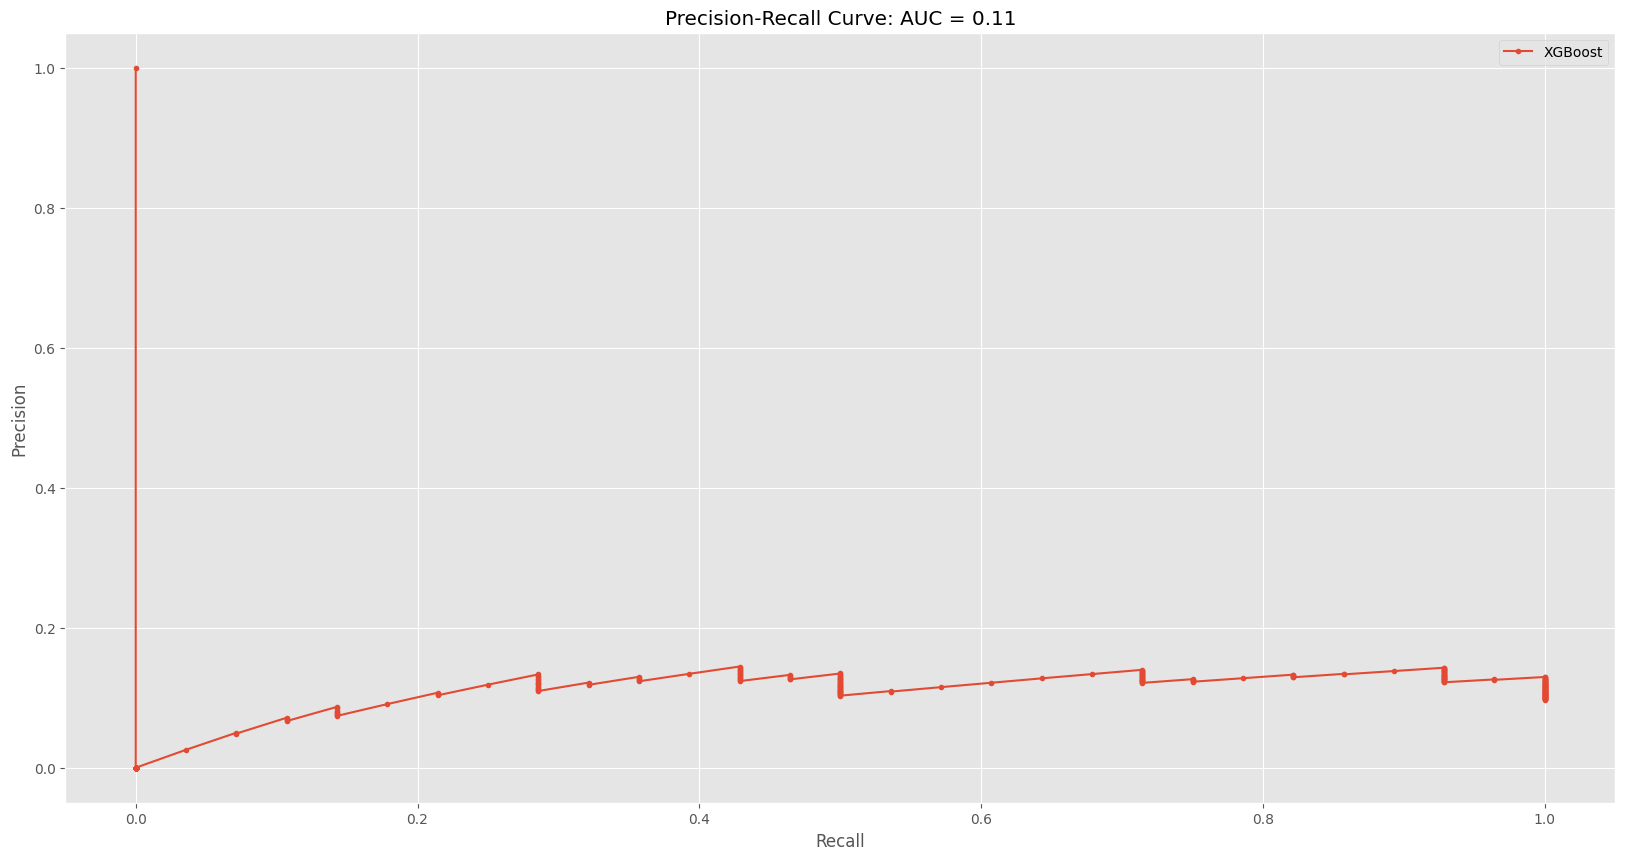

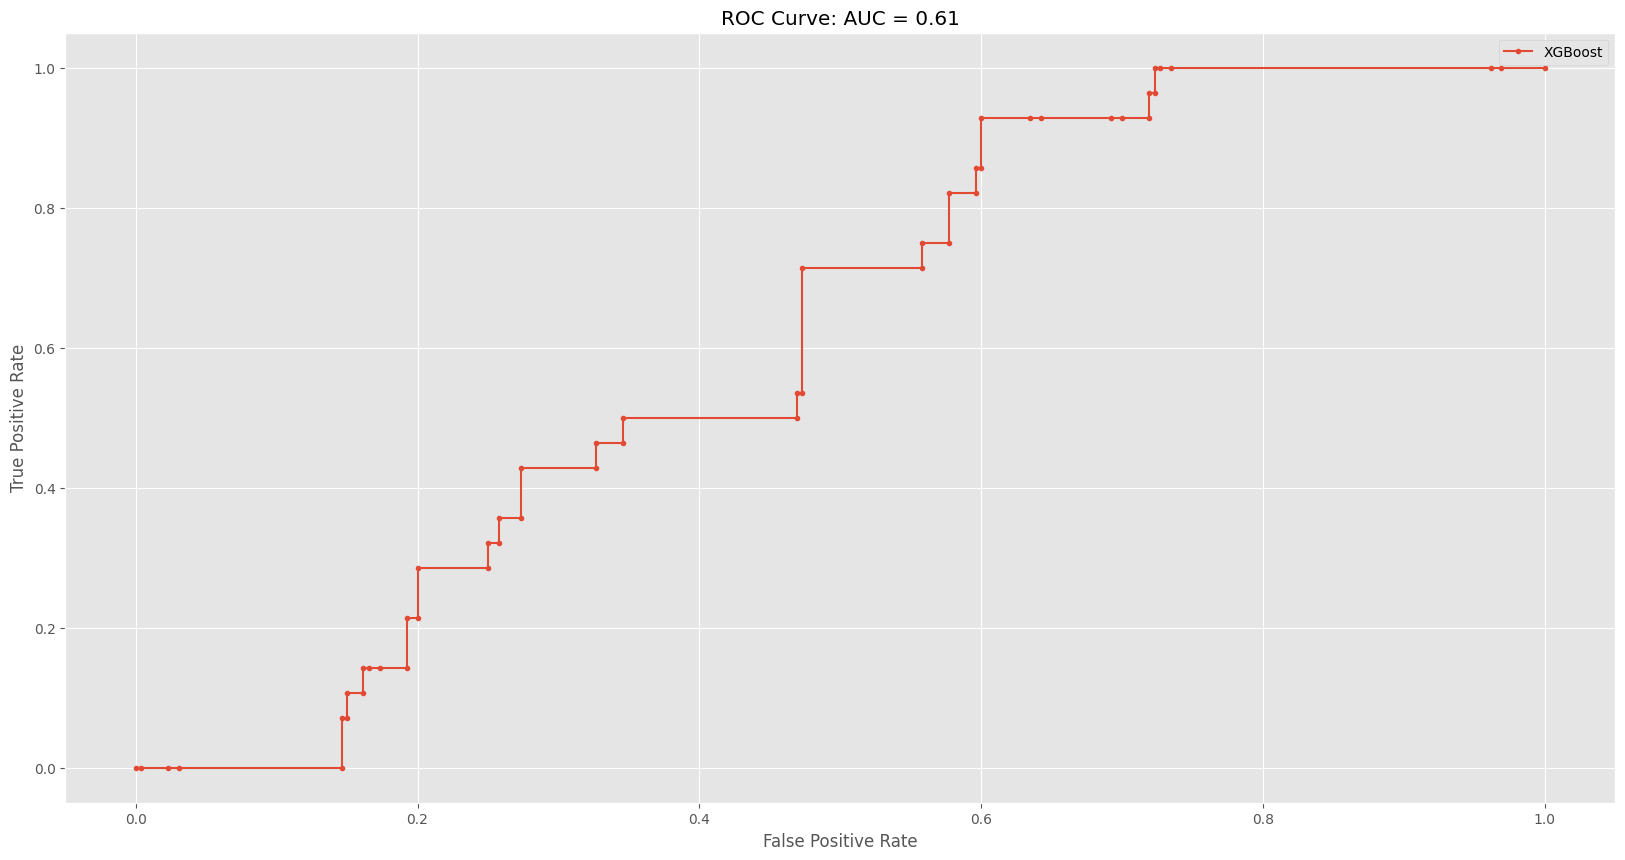

In [41]:
reload(h)
# Initialize an XGBoost classifier
model = xgb.XGBClassifier(**best, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = model.predict(X_val)

h.plot_metrics(y_val, y_pred, model, X_val)

In [4]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import helpers as h
import empatica_helpers as eh
import inquisit_helpers as ih
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from importlib import reload
reload(h), reload(eh), reload(ih)

# Global settings
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('ggplot') # nicer plots
pd.set_option('display.max_columns', None)
    
ei_prep = h.preprocess_data(save=True)
df = h.get_features(save=False)

Preprocessing data...


/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/helpers.py:130: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Normalised columns:  ['body_acc', 'temp', 'eda', 'bvp', 'hr']
Number of sessions before filtering: 67
Number of sessions after filtering: 63
Preprocessing complete.
Engineering features...


/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/helpers.py:187: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Feature engineering done!
